In [1]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [2]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pyg

In [3]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [4]:
# specify the local data path
HERE = Path("./data")
DATA = HERE 

In [5]:
# load dataset
qm9 = QM9(root=DATA)
qm9[0]

Extracting data\raw\qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [6]:
# get one regression target
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0])

qm9 = qm9.shuffle()

# data split
data_size = 30000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)


# normalizing the data
data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

c:\Users\friha\.conda\envs\NetSci\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\friha\.conda\envs\NetSci\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead

In [45]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class with 3 convolutional layers and a linear layer"""

    def __init__(self, dim_h):
        """init method for GCN

        Args:
            dim_h (int): the dimension of hidden layers
             num_features (int): the dimension of node features
        """
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)

        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

        self.seq1 = Sequential(
            BatchNorm1d(dim_h),
            ReLU(),
            Linear(dim_h, dim_h),
            ReLU()
        )
        self.seq2 = Sequential(
            BatchNorm1d(dim_h),
            ReLU(),
            Linear(dim_h, dim_h),
            ReLU()
        )
        self.seq3 = Sequential(
           BatchNorm1d(dim_h),
           ReLU(),
           Linear(dim_h, dim_h),
           ReLU()
        )

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = self.seq1(x)

        x = self.conv2(x, e)
        x = self.seq2(x)

        x = self.conv3(x, e)
        x = self.seq3(x)

        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)

        return x

In [8]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

In [9]:
def training(loader, model, loss, optimizer):
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d.x = d.x.float()

        out = model(d)

        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [10]:
def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    for d in loader:
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [11]:
@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    loss = torch.nn.MSELoss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for d in loader:
        out = model(d)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target

In [12]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target

In [51]:
# training GCN for 10 epochs
epochs = 10

model = GCN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GCN_model.pt"
)

Epoch: 0, Train loss: 0.696151852607727, Val loss: 0.5522415041923523
Epoch: 2, Train loss: 0.5233634114265442, Val loss: 0.43722739815711975
Epoch: 4, Train loss: 0.4573650658130646, Val loss: 0.4696086645126343
Epoch: 6, Train loss: 0.44696998596191406, Val loss: 0.4077497720718384
Epoch: 8, Train loss: 0.42622649669647217, Val loss: 0.4370787739753723


In [14]:
# Training GIN for 10 epochs
model = GIN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GIN_model.pt"
)

Epoch: 0, Train loss: 0.7221389412879944, Val loss: 0.6088637113571167
Epoch: 2, Train loss: 0.5387264490127563, Val loss: 0.48323720693588257
Epoch: 4, Train loss: 0.4833155572414398, Val loss: 0.5165597796440125
Epoch: 6, Train loss: 0.47127798199653625, Val loss: 0.5069313049316406
Epoch: 8, Train loss: 0.45522820949554443, Val loss: 0.419869989156723


In [52]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    """Plot the loss for each epoch

    Args:
        epochs (int): number of epochs
        train_loss (array): training losses for each epoch
        val_loss (array): validation losses for each epoch
    """
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [53]:
def plot_targets(pred, ground_truth):
    """Plot true vs predicted value in a scatter plot

    Args:
        pred (array): predicted values
        ground_truth (array): ground truth values
    """
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

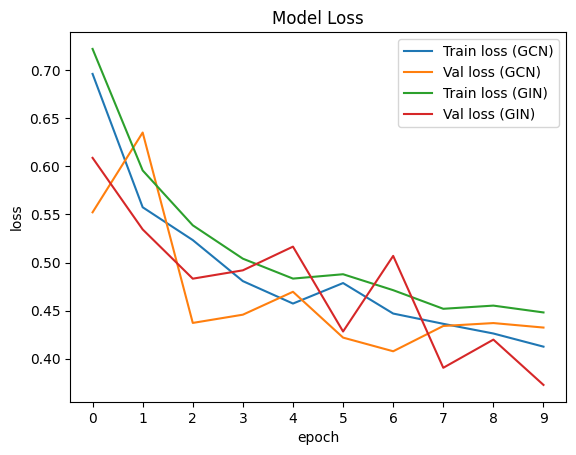

In [54]:
# Plot overall losses of GIN and GCN

plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss)

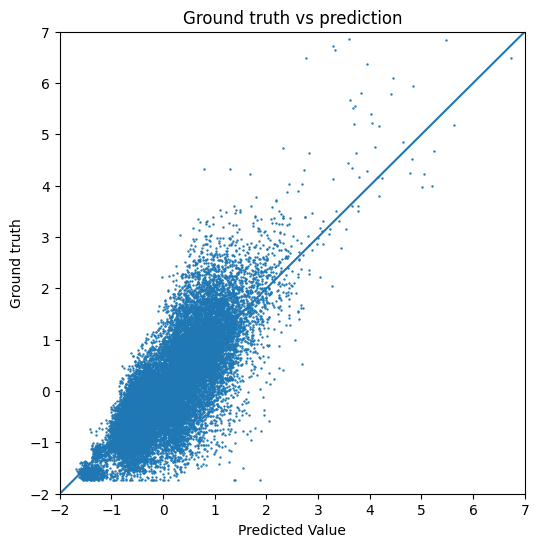

In [55]:
# Plot target and prediction for training data

plot_targets(gin_train_target, gin_train_y_target)

C:\Users\friha\AppData\Local\Temp\ipykernel_18008\1614852204.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("GCN_model.pt"))


Test Loss for GCN: 0.4268631041049957


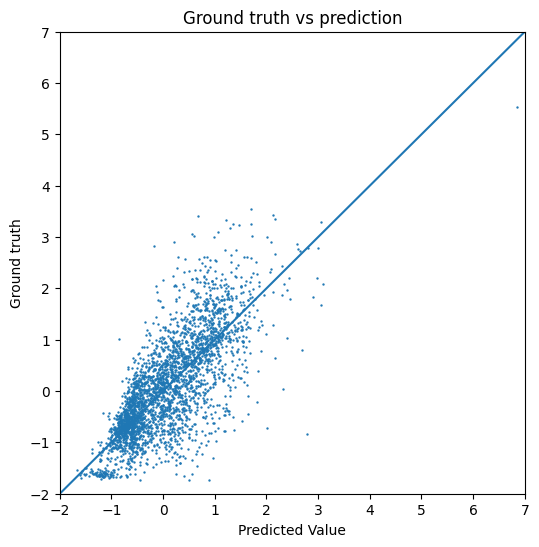

In [60]:
# Calculate test loss from the best GCN model (according to validation loss)

# load our model
model = GCN(dim_h=64)
model.load_state_dict(torch.load("GCN_model.pt"))

# calculate test loss
gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model)

print("Test Loss for GCN: " + str(gcn_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gcn_test_target, gcn_test_y)

C:\Users\friha\AppData\Local\Temp\ipykernel_18008\2373311285.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("GIN_model.pt"))


Test Loss for GIN: 0.41821953654289246


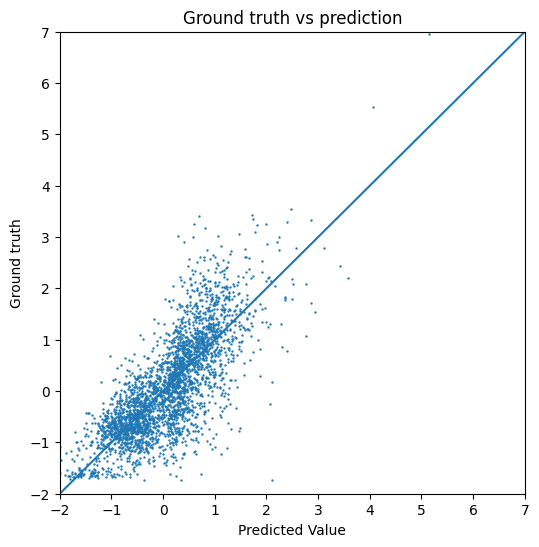

In [62]:
# Calculate test loss from the best GIN model (according to validation loss)

# load our model
model = GIN(dim_h=64)
model.load_state_dict(torch.load("GIN_model.pt"))

# calculate test loss
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model)

print("Test Loss for GIN: " + str(gin_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gin_test_target, gin_test_y)

In [ ]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, dim_h):
        """init method for GAT

         Args:
            dim_h (int): the dimension of hidden layers
            num_features (int): the dimension of node features
        """
        super(GAT, self).__init__()
        self.conv1 = GATConv(11, dim_h, heads=4)
        self.conv2 = GATConv(dim_h*4, dim_h, heads=4)
        self.conv3 = GATConv(dim_h*4, dim_h, heads=4)

        self.lin1 = Linear(dim_h*4, dim_h)
        self.lin2 = Linear(dim_h, 1)

        self.seq1 = Sequential(
            BatchNorm1d(dim_h*4),
            ReLU(),
            Linear(dim_h*4, dim_h*4),
            ReLU()
        )

        self.seq2 = Sequential(
            BatchNorm1d(dim_h*4),
            ReLU(),
            Linear(dim_h*4, dim_h*4),
            ReLU()
        )

        self.seq3 = Sequential(
            BatchNorm1d(dim_h*4),
            ReLU(),
            Linear(dim_h*4, dim_h*4),
            ReLU()
        )



    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = self.seq1(x)

        x = self.conv2(x, e)
        x = self.seq2(x)


        x = self.conv3(x, e)
        x = self.seq3(x)

        x = global_mean_pool(x, data.batch)
        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)

        return x

In [44]:
# Training GAT for 10 epochs
epochs = 10
model = GAT(dim_h=64)
gat_train_loss, gat_val_loss, gat_train_target, gat_train_y_target = train_epochs(epochs, model, train_loader, val_loader, "GAT_model.pt")

Epoch: 0, Train loss: 0.6595125198364258, Val loss: 0.5784116983413696
Epoch: 2, Train loss: 0.5350751280784607, Val loss: 0.5258994102478027
Epoch: 4, Train loss: 0.4772440195083618, Val loss: 0.44912534952163696
Epoch: 6, Train loss: 0.46994295716285706, Val loss: 0.44008034467697144
Epoch: 8, Train loss: 0.4413362443447113, Val loss: 0.42690375447273254


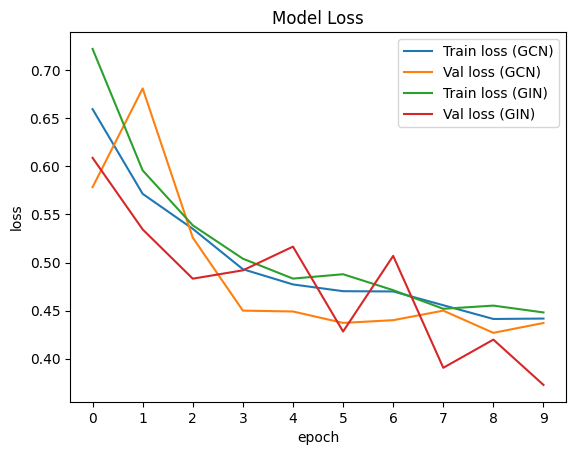

In [46]:
# plotting the loss
plot_loss(gat_train_loss, gat_val_loss, gin_train_loss, gin_val_loss)

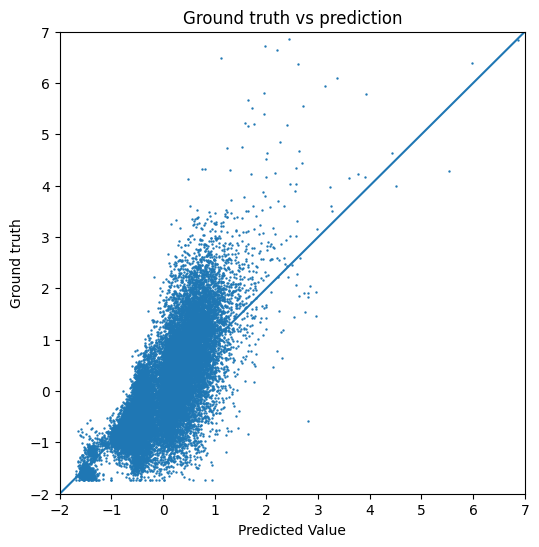

In [47]:
# Plotting training predictions
plot_targets(gat_train_target, gat_train_y_target)

In [69]:
# Calculate test loss
model = GAT(dim_h=64)
model.load_state_dict(torch.load("GAT_model.pt"))
gat_test_loss, gat_test_target, gat_test_y = testing(test_loader, model)
print("Test Loss for GAT: " + str(gat_test_loss.item()))

C:\Users\friha\AppData\Local\Temp\ipykernel_18008\3518757417.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("GAT_model.pt"))


Test Loss for GAT: 0.46240121126174927


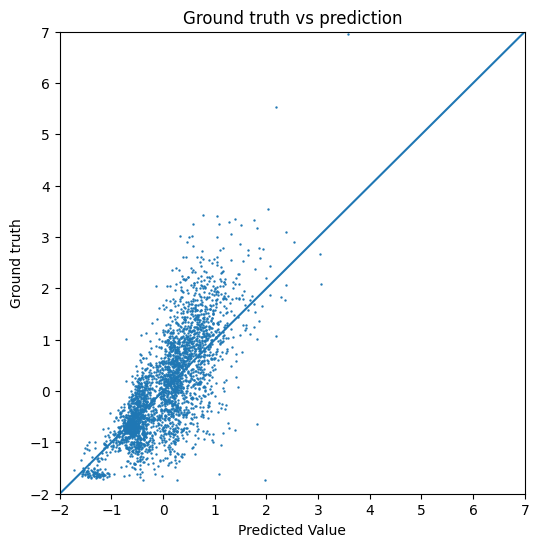

In [70]:
# Plot test predictions
plot_targets(gat_test_target, gat_test_y)

In [94]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
class MPNNConv(MessagePassing):
    """
    Custom Message Passing layer for MPNN.
    """
    def __init__(self, dim_h, edge_dim):
        super(MPNNConv, self).__init__(aggr='add')
        self.mlp_msg = Sequential(
            Linear(dim_h + edge_dim, dim_h),  # Input: concatenated x_i, x_j, and edge_attr
            BatchNorm1d(dim_h),
            ReLU(),
            Linear(dim_h, dim_h),
            ReLU()
        )
        self.mlp_update = Sequential(
            Linear(2 * dim_h, dim_h),  # Input: concatenated x and aggregated messages
            BatchNorm1d(dim_h),
            ReLU()
        )

    def forward(self, x, edge_index, edge_attr):
        """Propagate the messages and return the updated node features."""
        # Add self loops to edge_index if missing, this is useful in some cases.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        """Define the message function."""
        # Concatenate node features with edge attributes
        message = torch.cat([x_i, x_j, edge_attr], dim=-1)
        return self.mlp_msg(message)


    def update(self, inputs, x):
         """Define the node update function."""
        # Concatenate the node features with the aggregated messages
         message = torch.cat([x, inputs], dim=-1)
         return self.mlp_update(message)


class MPNN(torch.nn.Module):
    """
    Full MPNN model with node and edge embeddings.
    """
    def __init__(self, dim_h, num_features, edge_dim):
        super(MPNN, self).__init__()
        self.node_embedding = Sequential(
            Linear(num_features, dim_h),
            ReLU()
        )
        self.edge_embedding = Sequential(
            Linear(edge_dim, dim_h),
            ReLU()
        )
        self.conv1 = MPNNConv(dim_h, dim_h)
        self.conv2 = MPNNConv(dim_h, dim_h)
        self.conv3 = MPNNConv(dim_h, dim_h)
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x
        edge_attr = data.edge_attr

        x = self.node_embedding(x)
        edge_attr = self.edge_embedding(edge_attr)
        x = self.conv1(x, e, edge_attr)
        x = x.relu(x)

        x = self.conv2(x, e, edge_attr)
        x = x.relu(x)

        x = self.conv3(x, e, edge_attr)

        x = global_mean_pool(x, data.batch)
        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)

        return x

In [92]:
# Training MPNN for 10 epochs
epochs = 10
model = MPNN(dim_h=64, num_features=qm9.num_features, edge_dim = qm9.num_edge_features)
gat_train_loss, gat_val_loss, gat_train_target, gat_train_y_target = train_epochs(epochs, model, train_loader, val_loader, "MPNN_model.pt")

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3473 but got size 2344 for tensor number 2 in the list.

In [ ]:
from torch_geometric.nn import  TransformerConv
class GTN(torch.nn.Module):
    def __init__(self, dim_h, num_features, edge_dim):
        super(GTN, self).__init__()
        self.node_embedding = Sequential(
            Linear(num_features, dim_h),
            ReLU()
        )
        self.edge_embedding = Sequential(
            Linear(edge_dim, dim_h),
            ReLU()
        )
        self.dim_h = dim_h
        self.edge_projection = Linear(dim_h, dim_h*4) # project to correct dimension
        self.conv1 = TransformerConv(dim_h, dim_h, heads=4)
        self.bn1 = BatchNorm1d(dim_h*4)
        self.conv2 = TransformerConv(dim_h * 4, dim_h, heads=4)
        self.bn2 = BatchNorm1d(dim_h*4)
        self.conv3 = TransformerConv(dim_h * 4, dim_h, heads=4)
        self.bn3 = BatchNorm1d(dim_h*4)
        self.lin = Linear(dim_h * 4, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.node_embedding(x)
        edge_attr = self.edge_embedding(edge_attr)
        edge_attr = self.edge_projection(edge_attr).view(-1,4,self.dim_h) # project to [num_edges, num_heads, dim_h]

        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = Fun.relu(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = Fun.relu(x)

        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn3(x)
        x = global_mean_pool(x, data.batch)
        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

<bound method InMemoryDataset.get of QM9(130831)>

In [110]:
# Training GTN for 10 epochs
epochs = 10
model = GTN(dim_h=64, num_features=qm9.num_features, edge_dim = qm9.num_edge_features)
gtn_train_loss, gtn_val_loss, gtn_train_target, gtn_train_y_target = train_epochs(epochs, model, train_loader, val_loader, "GTN_model.pt")

TypeError: TensorBase.relu() takes no arguments (1 given)